In [3]:
### Imports ###

from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
import os # for deleting files
import calendar

### Get data ###
URL_2020 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv'
URL_2019 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv'
URL_2018 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv'
URL_2017 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv' 

urlretrieve(URL_2020,'derby_2020.csv')
urlretrieve(URL_2019,'derby_2019.csv')
urlretrieve(URL_2018,'derby_2018.csv')
urlretrieve(URL_2017,'derby_2017.csv')

df_2020 = pd.read_csv('derby_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
df_2019 = pd.read_csv('derby_2019.csv',skiprows=4)
df_2018 = pd.read_csv('derby_2018.csv',skiprows=4)
df_2017 = pd.read_csv('derby_2017.csv',skiprows=4)
unit = 'ugm^3'

# Removing the .csv files
os.remove('derby_2020.csv')
os.remove('derby_2019.csv')
os.remove('derby_2018.csv')
os.remove('derby_2017.csv')

### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00

def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])

    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value

    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
    # setting index to be the date time
    variable.index = variable['Date Time']


datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all_index = df_all.copy()
df_all_index.index = df_all_index['Date Time']

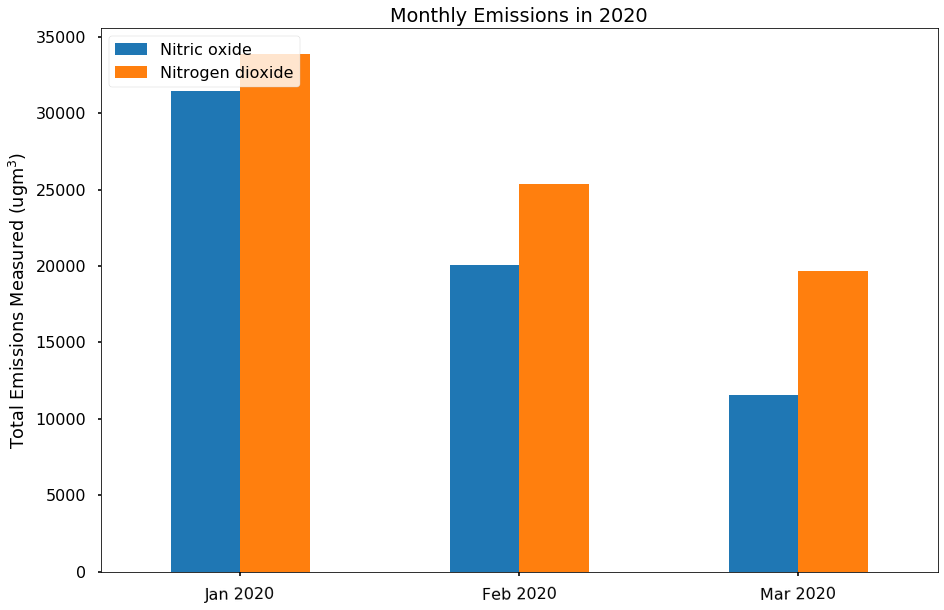

In [7]:
### ADDING START AND END DATE ###

# function to let you decide date range to plot
def plot_date_range(start,end,resample_string,plottype,aggregate):
    '''
    Parameters:
    start = date string in format YYYY-MM-DD
    end = date string in format YYYY-MM-DD
    resample = string of 'H'/'D'/'W'/'M'
    plottype = string 'line' or 'bar'
    aggregate = string 'sum','average','median'
    '''
    resample_string = resample_string.upper() # just in case user were to input h instead of H
    
    # for title of chart
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # dates to plot 
    start = datetime.strptime(start,'%Y-%m-%d')
    end = datetime.strptime(end,'%Y-%m-%d')
    
    # resampling based on input
    if resample_string == 'H':
        z = df_all_index.loc[start:end]
        if plottype == 'line':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        x.set_title('Hourly Emissions Between {} and {}'.format(start,end))
        x.set_ylim(0)
    else:    
        z = df_all_index.loc[start:end]
        if plottype == 'line':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            x.set_title('{} {} Emissions Between {} and {}'.format(aggregate.title(),title_string,start,end))
            x.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            x.set_title('{} {} Emissions Between {} and {}'.format(aggregate.title(),title_string,start,end))
            x.set_ylim(0)
            
            plt.xticks(np.arange(3),['Jan 2020','Feb 2020','Mar 2020'])
            plt.xticks(rotation=1)
            plt.title('Monthly Emissions in 2020')
            plt.xlabel('')
            plt.ylabel('Total Emissions Measured (ugm$^3$)')
            plt.legend(loc='upper left')
            
plot_date_range('2020-01-01','2020-03-31','M','bar','sum')

# Hard coded graph for looking at daily March emmisions for each day 

<Figure size 1080x720 with 0 Axes>

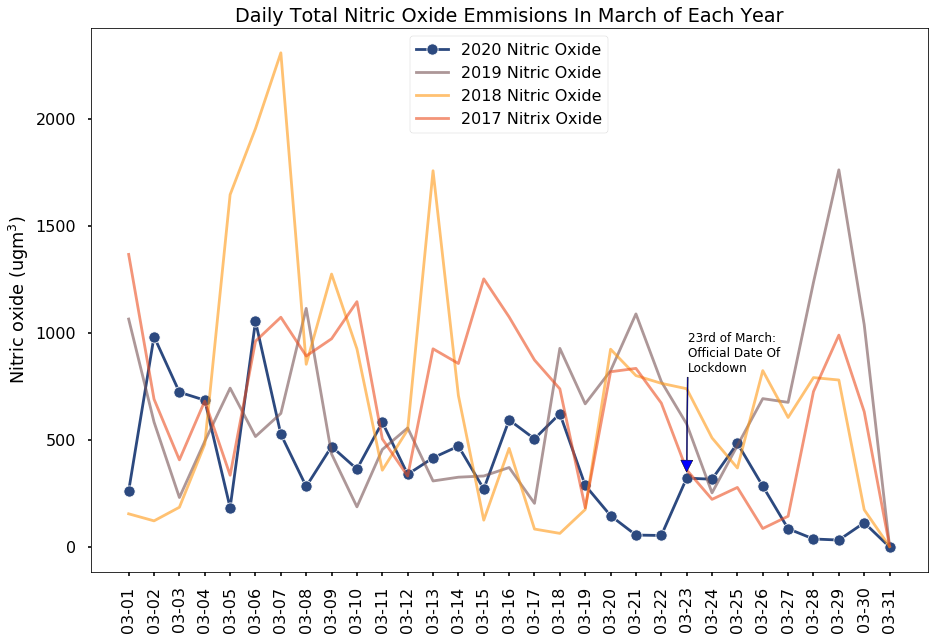

In [56]:
# user enters start and end date to compare in format 'MM-DD'
# mask of each year to only show between these dates
# make plot for each year and stack them on top of each other as subplots

def year_comparison(start,end,resample_string):
    global df_2020, df_2019, df_2018, df_2017
    '''
    Parameters:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D','W','M'
    '''
   
    # below is hideous but I'm just doing it in this dumb way because I know it'll work
    # gets you start and end dates for each year
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    ### MASKS ###
    # 2020
    mask = (df_2020['Date Time'] >= start_2020) & (df_2020['Date Time'] <= end_2020) # REPLACE MASKS WITH .LOC!
    df_2020_ = df_2020.loc[mask]
    # 2019
    mask = (df_2019['Date Time'] >= start_2019) & (df_2019['Date Time'] <= end_2019) # REPLACE MASKS WITH .LOC!
    df_2019_ = df_2019.loc[mask]
    # 2018
    mask = (df_2018['Date Time'] >= start_2018) & (df_2018['Date Time'] <= end_2018) # REPLACE MASKS WITH .LOC!
    df_2018_ = df_2018.loc[mask]
    # 2017
    mask = (df_2017['Date Time'] >= start_2017) & (df_2017['Date Time'] <= end_2017) # REPLACE MASKS WITH .LOC!
    df_2017_ = df_2017.loc[mask]
    
    if resample_string=='H':
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_['Date Time'].dt.strftime('%m-%d %H:%M')

        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'])
        sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'])
        #sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'])
        #sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'])
    
    elif resample_string!='H':
        ### Resample accordingly 
        plt.figure(figsize=(15,10))
        df_2020_ = df_2020_.resample(resample_string).sum()
        df_2019_ = df_2019_.resample(resample_string).sum()
        df_2018_ = df_2018_.resample(resample_string).sum()
        df_2017_ = df_2017_.resample(resample_string).sum()
        
        # this strips away the Date Time No Year column, have to make a new one
        
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_.index.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_.index.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_.index.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_.index.strftime('%m-%d %H:%M')
        
        #### Replacing date time as index as removing datatime column 
        def cleaner(variable):
            variable.index = variable['Date Time No Year']
        #    variable.drop(['Date Time'],axis=1)
        
        cleaner(df_2020_)
        cleaner(df_2019_)
        cleaner(df_2018_)
        cleaner(df_2017_)
        
        #return df_2017_
        
        ### Plotting them with date time no year
        #plt.style.use('seaborn-dark')
        plt.style.use('seaborn-poster')

        plt.figure(figsize=(15,10))
        
        #plt.patch.set_facecolor(color='#C6D2ED')
        sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                     label='2020 Nitric Oxide',linestyle='-',marker='o',alpha=1,color='#2C497F')
        sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                     label='2019 Nitric Oxide',linestyle=':',alpha=0.6,color='#775253')
        sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],
                     label='2018 Nitric Oxide',alpha=0.6,linestyle=':',color='#FF9914')
        sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'],
                     label='2017 Nitrix Oxide',alpha=0.6,linestyle='-.',color='#EC4E20')
        
        #plt.title('Daily March Nitric Oxide Emissions Per Year')
        plt.xticks(rotation=90)
        plt.xlabel('')
        plt.ylabel('Nitric oxide (ugm$^3$)')
        plt.title('Daily Total Nitric Oxide Emmisions In March of Each Year')
        plt.legend(loc='upper center')
        # want to annotate the 23rd of March
        # will be in index as '03-23'
        plt.annotate(s='23rd of March: \nOfficial Date Of \nLockdown',
                     xy=('03-23 00:00',350),
                     xytext=(1,100),
                     xycoords='data',
                     textcoords='offset points',
                    arrowprops=dict(width=1,fc='b'),
                    fontsize=12)
        xticks(np.arange(31),['03-01','03-02','03-03','03-04','03-05','03-06','03-07','03-08','03-09','03-10',
                             '03-11','03-12','03-13','03-14','03-15','03-16','03-17','03-18','03-19','03-20',
                             '03-21','03-22','03-23','03-24','03-25','03-26','03-27','03-28','03-29','03-30',
                              '03-31'])
        #arrowprops=dict(arrowstyle='-|>')
    
        #ax.annotate('local max', xy=(3, 1),  xycoords='data',
        #    xytext=(0.8, 0.95), textcoords='axes fraction',
        #    arrowprops=dict(facecolor='black', shrink=0.05),
        #    horizontalalignment='right', verticalalignment='top',
        #    )
        
year_comparison('03-01','03-31','D') # WOULD BE GREAT TO ADD AN ARROR TO THIS TO SHOW WHEN THE LOCKDOWN WAS ANNOUNCED

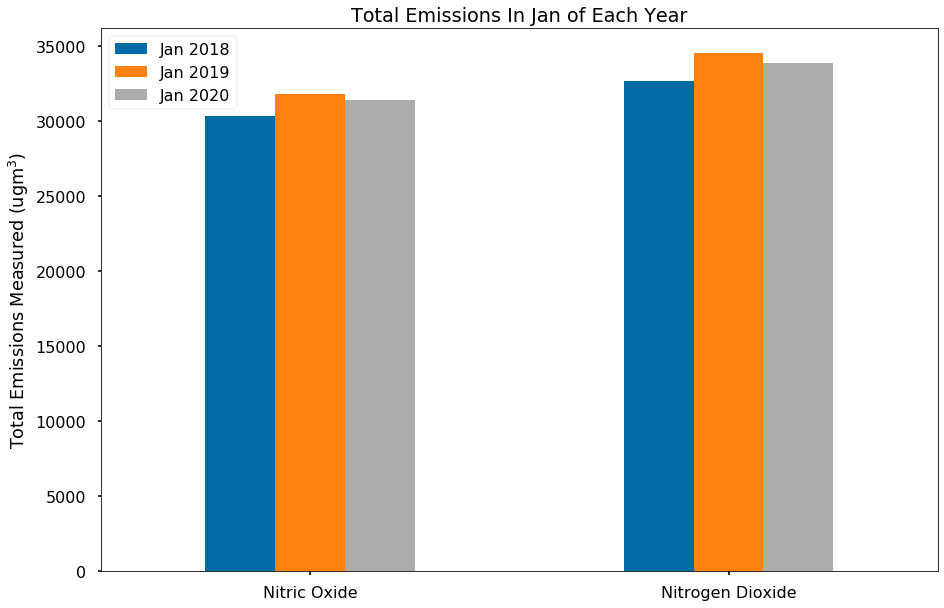

In [8]:
march_17 = df_all.loc['2017-01-01':'2017-01-31']
march_18 = df_all.loc['2018-01-01':'2018-01-31']
march_19 = df_all.loc['2019-01-01':'2019-01-31']
march_20 = df_all.loc['2020-01-01':'2020-01-31']

mar_17_no = march_17['Nitric oxide'].sum()
mar_17_nd = march_17['Nitrogen dioxide'].sum()

mar_18_no = march_18['Nitric oxide'].sum()
mar_18_nd = march_18['Nitrogen dioxide'].sum()

mar_19_no = march_19['Nitric oxide'].sum()
mar_19_nd = march_19['Nitrogen dioxide'].sum()

mar_20_no = march_20['Nitric oxide'].sum()
mar_20_nd = march_20['Nitrogen dioxide'].sum()

data = {
       'Jan 2018':[mar_18_no, mar_18_nd],
        'Jan 2019':[mar_19_no, mar_19_nd],
        'Jan 2020':[mar_20_no, mar_20_nd]} # 2017 deleted as data didn't start on Jan 1st

df = pd.DataFrame(data)
df.index = ['Nitric Oxide','Nitrogen Dioxide']
df

plt.style.use('tableau-colorblind10')
df.plot.bar(figsize=[15,10])
plt.title('Total Emissions In Jan of Each Year')
plt.ylabel('Total Emissions Measured (ugm$^3$)')
plt.xticks(rotation=0)
plt.legend(loc='upper left')

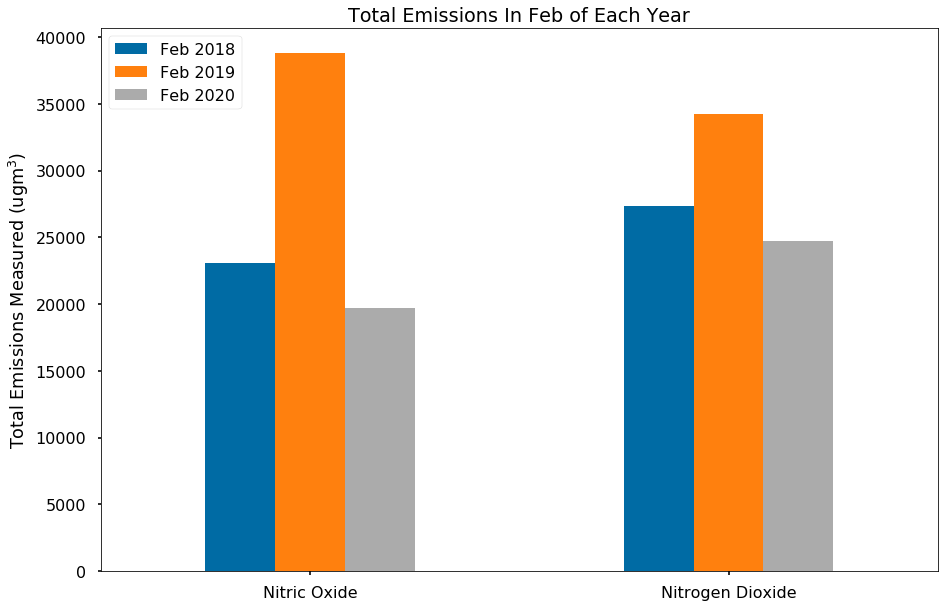

In [9]:
march_17 = df_all.loc['2017-02-01':'2017-02-28']
march_18 = df_all.loc['2018-02-01':'2018-02-28']
march_19 = df_all.loc['2019-02-01':'2019-02-28']
march_20 = df_all.loc['2020-02-01':'2020-02-28']

mar_17_no = march_17['Nitric oxide'].sum()
mar_17_nd = march_17['Nitrogen dioxide'].sum()

mar_18_no = march_18['Nitric oxide'].sum()
mar_18_nd = march_18['Nitrogen dioxide'].sum()

mar_19_no = march_19['Nitric oxide'].sum()
mar_19_nd = march_19['Nitrogen dioxide'].sum()

mar_20_no = march_20['Nitric oxide'].sum()
mar_20_nd = march_20['Nitrogen dioxide'].sum()

data = {
       'Feb 2018':[mar_18_no, mar_18_nd],
        'Feb 2019':[mar_19_no, mar_19_nd],
        'Feb 2020':[mar_20_no, mar_20_nd]}

df = pd.DataFrame(data)
df.index = ['Nitric Oxide','Nitrogen Dioxide']
df

plt.style.use('tableau-colorblind10')
df.plot.bar(figsize=[15,10])
plt.title('Total Emissions In Feb of Each Year')
plt.ylabel('Total Emissions Measured (ugm$^3$)')
plt.xticks(rotation=0)
plt.legend(loc='upper left')

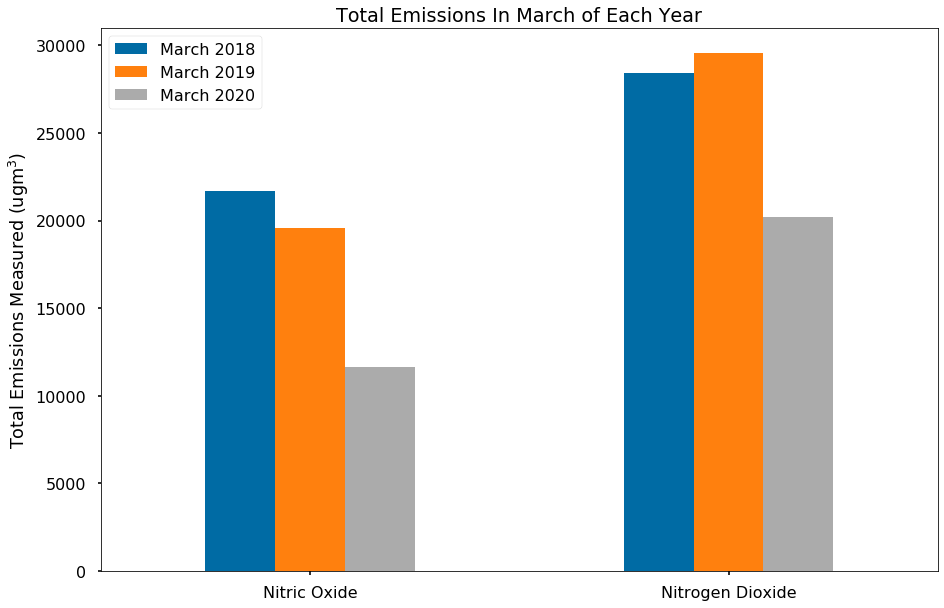

In [10]:
march_17 = df_all.loc['2017-03-01':'2017-03-31']
march_18 = df_all.loc['2018-03-01':'2018-03-31']
march_19 = df_all.loc['2019-03-01':'2019-03-31']
march_20 = df_all.loc['2020-03-01':'2020-03-31']

mar_17_no = march_17['Nitric oxide'].sum()
mar_17_nd = march_17['Nitrogen dioxide'].sum()

mar_18_no = march_18['Nitric oxide'].sum()
mar_18_nd = march_18['Nitrogen dioxide'].sum()

mar_19_no = march_19['Nitric oxide'].sum()
mar_19_nd = march_19['Nitrogen dioxide'].sum()

mar_20_no = march_20['Nitric oxide'].sum()
mar_20_nd = march_20['Nitrogen dioxide'].sum()

data = {
       'March 2018':[mar_18_no, mar_18_nd],
        'March 2019':[mar_19_no, mar_19_nd],
        'March 2020':[mar_20_no, mar_20_nd]}

df = pd.DataFrame(data)
df.index = ['Nitric Oxide','Nitrogen Dioxide']
df

#plt.style.use('seaborn-poster')
plt.style.use('tableau-colorblind10')
df.plot.bar(figsize=[15,10])
plt.title('Total Emissions In March of Each Year')

plt.ylabel('Total Emissions Measured (ugm$^3$)')
plt.xticks(rotation=0)
plt.legend(loc='upper left')

In [52]:
def month_comparison(month_str):
    '''
    month_str = month in two digit format i.e. March = 03
    '''
    months_with_31_days=['01','03','05','07','08','10','12']
    months_with_30_days=['4','6','9','11']
    
    if month_str == '02':
        days_in_month = 10
    elif month_str in(months_with_31_days):
        days_in_month = 31
    elif month_str in(months_with_30_days):
        days_in_month=30
    
    # getting month name for title of plot
    monthinteger = int(month_str)
    month = calendar.month_name[monthinteger]
    
    month_17 = df_all.loc['2017-{}-01'.format(month_str):'2017-{}-{}'.format(month_str,days_in_month)] 
    month_18 = df_all.loc['2018-{}-01'.format(month_str):'2018-{}-{}'.format(month_str,days_in_month)]
    month_19 = df_all.loc['2019-{}-01'.format(month_str):'2019-{}-{}'.format(month_str,days_in_month)]
    month_20 = df_all.loc['2020-{}-01'.format(month_str):'2020-{}-{}'.format(month_str,days_in_month)]

    month_17_no = month_17['Nitric oxide'].sum()
    month_17_nd = month_17['Nitrogen dioxide'].sum()

    month_18_no = month_18['Nitric oxide'].sum()
    month_18_nd = month_18['Nitrogen dioxide'].sum()

    month_19_no = month_19['Nitric oxide'].sum()
    month_19_nd = month_19['Nitrogen dioxide'].sum()

    month_20_no = month_20['Nitric oxide'].sum()
    month_20_nd = month_20['Nitrogen dioxide'].sum()

    # Making a new dataframe to plot
    data = {'{}-2017'.format(month_str):[month_17_no,month_17_nd],
           '{}-2018'.format(month_str):[month_18_no, month_18_nd],
            '{}-2019'.format(month_str):[month_19_no, month_19_nd],
            '{}-2020'.format(month_str):[month_20_no, month_20_nd]}

    df = pd.DataFrame(data)
    df.index = ['Nitric Oxide','Nitrogen Dioxide']
    df

    #plt.style.use('seaborn-poster')
    plt.style.use('tableau-colorblind10')
    df.plot.bar(figsize=[15,10])
    plt.title('Total Emissions In {} of Each Year'.format(month))

    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')

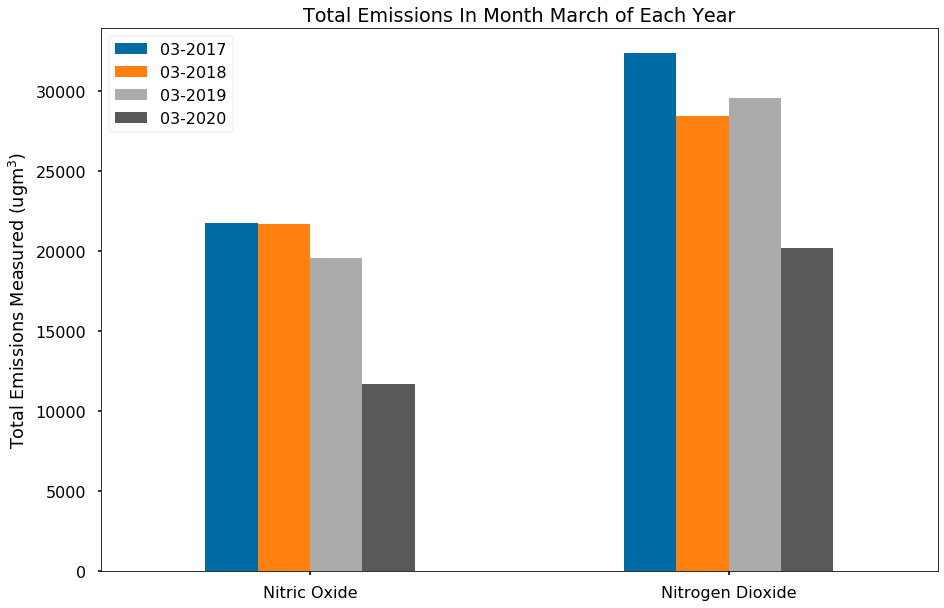

In [55]:
month_comparison('03')